In [1]:
P = HyperbolicPlane().PD()

In [2]:
# transform
def xi(z):
    return (i * z + 1) / (- z - i)

In [3]:
def xi_inv(z):
    return (-i * z - 1) / ( z + i)

In [167]:
eta = [-1,-0.5,0.25, 0.5, 0.75, 1]
code = [0,2,1,3,2,4,3,5,4,6,5,1]

In [168]:
# build reflections
r = []
for l in range(1,len(eta)):
    r.append(1/(eta[l]-eta[l-1]) * Matrix([[eta[l-1]+eta[l], - 2 * eta[l-1] * eta[l]], [2, -(eta[l-1]+eta[l])]]))
    #print(det(r[l]))
r.append(Matrix([[-1, 2], [0,1]]))
r.append(Matrix([[-1, -2],[0, 1]]))

In [169]:
# build T
T = matrix.identity(2)
for l in range(len(code)):
    T = T * r[code[l]]
# find ideal endpoints
diskr = sqrt((T[1,1]-T[0,0])^2 + 4 * T[0,1] * T[1, 0])
x_1 = ((T[0,0]-T[1,1]) + diskr ) / (2 * T[1,0])
x_2 = ((T[0,0]-T[1,1]) - diskr ) / (2 * T[1,0])
# the ideal endpoints
z_1 = xi_inv(x_1)
z_2 = xi_inv(x_2)

In [170]:
def refl(r,z):
    if z!= -i:
        return xi_inv((r[0,0] * conjugate(xi(z)) +r[0,1]) / (r[1,0] * conjugate(xi(z)) +r[1,1]))
    else:
        if r[1,0] != 0:
            return xi_inv(r[0,0]/r[1,0])
        else:
            return -i

In [187]:
def getLength(code):
    T = matrix.identity(2)
    for l in range(len(code)):
        T = T * r[code[l]]
    return arccosh(0.5 * (T[0,0]+T[1,1])^2 + (-1)^(len(code)))

In [175]:
# initialize billiard table
#build points
points = []
for j in range(len(eta)):
    points.append(xi_inv(eta[j]))
points.append(-i)
print(points)
k = len(points)
# build sides
sides = []
for j in range(k):
    sides.append(P.get_geodesic(points[j],points[(j+1)% k]))
g_tmp = P.get_geodesic(z_1,z_2)

#find first segment
ends =[]
j_tmp = []
for j in range(k):
    if not g_tmp.is_parallel(sides[j]):
        # find endpoint of new segment
        ends.append(g_tmp.intersection(sides[j])[0].coordinates())
        j_tmp.append(j)
g = []
g.append(P.get_geodesic(ends[0],ends[1]))
cod = []
if abs(g[0].end().coordinates()-ends[0]) < 10^(-6):
    cod.append(j_tmp[0])
else:
    cod.append(j_tmp[1])

for ite in range(len(code)-1):
    print("iteration", ite)
    #print("g size", g)
    # If we do not numerically approximate, we obtain problems, don't know why...
    g[ite] = P.get_geodesic(numerical_approx(g[ite].start().coordinates()), numerical_approx(g[ite].end().coordinates()))
    start = numerical_approx(sides[cod[ite]].intersection(g[ite].complete())[0].coordinates())
    #print("start ", start )
    #print("cod", cod[ite])
    
    # to find the new segment, we reflect the billiard table along the hitting side, find the next hit and reflect
    # the found trajectory back
    
    #extend the trajectory
    #print(numerical_approx(g[ite].start().coordinates()))
    g_comp = g[ite].complete()
    #reflect the sides
    refl_sides = [None] * k
    #isometry = sides[cod[ite]].reflection_involution()
    isometry = r[cod[ite]]
    for j in range(k):
        if j != cod[ite]:
            #refl_sides[j] = isometry * sides[j]
            refl_sides[j] = P.get_geodesic(refl(isometry,sides[j].start().coordinates()),refl(isometry,sides[j].end().coordinates()))
            if not g_comp.is_parallel(refl_sides[j]):
                print("j ", j )
                # find endpoint of new segment
                end = g_comp.intersection(refl_sides[j])[0].coordinates()
                # build new geodesic
                #g_tmp = P.get_geodesic(start, end)
                # re-unfold geodsic
                #g.append(isometry * g_tmp)
                g.append(P.get_geodesic(refl(isometry,start), refl(isometry,end)))
                cod.append(j)

[1, 0.800000000000000 + 0.600000000000000*I, -0.470588235294118 + 0.882352941176471*I, -0.800000000000000 + 0.600000000000000*I, -0.960000000000000 + 0.280000000000000*I, -1, -I]
iteration 0
j  5
iteration 1
j  6
iteration 2
j  4
iteration 3
j  5
iteration 4
j  3
iteration 5
j  4
iteration 6
j  2
iteration 7
j  3
iteration 8
j  1
iteration 9
j  2
iteration 10
j  0


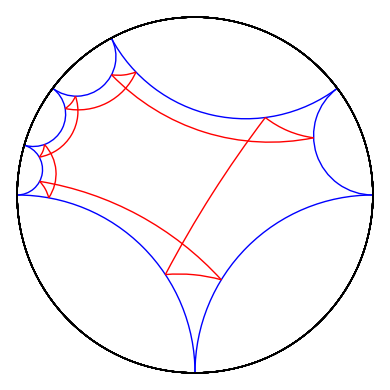

In [195]:
#print(refl_sides)
pl = sides[0].plot(color="blue") 
for j in range(1,k):
    pl = pl + sides[j].plot(color="blue") 
for j in range(len(cod)):
    pl = pl + g[j].plot(color="red")
#for j in range(4):
#    if  refl_sides[j]!= None:
#        pl = pl + refl_sides[j].plot(color = "green")
show(pl)

In [188]:
print(getLength(code))

21.5316013783975


In [189]:
# Möbiustranform, mapping line of D to line in H and then to imaginary axis in H
def m(a,b,z):
    # remember, an element of Möb(H) with real coefficient must have positive determinant, hence the distinction
    ma = max(xi(a).real(), xi(b).real())
    mi = min(xi(a).real(), xi(b).real())
    return (xi(z) - ma)/(xi(z) - mi)

In [190]:
# the geodesic in the half plane model
def gamma_H(s,e,t):
    # depending on whether the starting point s is below or above the ending point s, we move upwards or downwards,
    # respectively
    if m(a,b,s).imag() < m(a,b,e).imag():
        return m(a,b,s) * exp(t)
    else:
        return m(a,b,s) * exp(-t)

In [191]:
def m_inv(a,b,z):
    # remember, an element of Möb(H) with real coefficient must have positive determinant, hence the distinction
    ma = max(xi(a).real(), xi(b).real())
    mi = min(xi(a).real(), xi(b).real())

    return ((1 + i * mi) * z - 1 - i * ma) / ((-i - mi) * z + i + ma)

In [192]:
def gamma_D(s,e,a,b,t):
    return m_inv(a,b, gamma_H(s,e,t))

In [197]:
cnt=0
for ite in range(len(cod)):
    s = g[ite].start().coordinates()
    e = g[ite].end().coordinates()
    # find ideal points of geodesic
    a = g[ite].complete().start().coordinates()
    b = g[ite].complete().end().coordinates()
    # initialize time step
    delta_t = 0.05
    # initialize time 
    t=0
    # initialize time until hit
    t_hit = abs(ln(m(a,b,s) / m(a,b,e)))

    # save the images of the ball follwing the trajectory
    for j in range(floor(t_hit / delta_t)):
        pl_temp = pl + P.get_point(gamma_D(s,e,a,b,t)).show(color="green")
        t = t + delta_t
        save(pl_temp, "parametrization"+ str(cnt) +".png")
        cnt = cnt +1